`python3 -m pip install -U pandas plotly nbformat`

`pip install "https://github.com/DCMLab/wavescapes/archive/refs/heads/johannes.zip"`

In [1]:
%reload_ext autoreload
%autoreload 2
import numpy as np

from etl import get_dfts, get_mag_phase_mx, get_metadata, get_most_resonant, get_pcms, get_pcvs, test_dict_keys, \
  get_correlations, make_feature_vectors, get_metric, get_most_resonant_penta_dia

from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from utils import get_coeff

from wavescapes.color import circular_hue

C:\Users\ludov\anaconda3\envs\ada\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
C:\Users\ludov\anaconda3\envs\ada\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


## Settings

In [2]:
DEBUSSY_REPO = '.'
DATA_FOLDER = '~/DATA/debussy_figures/data'
DATA_FOLDER = './data'
EXAMPLE_FNAME = 'l000_etude'
LONG_FORMAT = False

## Loading metadata
Metadata for all pieces contained in the dataset.

In [3]:
metadata = get_metadata(DEBUSSY_REPO)
metadata.columns

Metadata for 82 files.


Index(['rel_paths', 'last_mc', 'last_mn', 'length_qb', 'length_qb_unfolded',
       'all_notes_qb', 'n_onsets', 'TimeSig', 'KeySig', 'label_count',
       'composer', 'workTitle', 'movementNumber', 'movementTitle',
       'workNumber', 'poet', 'lyricist', 'arranger', 'copyright',
       'creationDate', 'mscVersion', 'platform', 'source', 'translator',
       'musescore', 'ambitus', 'comment', 'comments', 'composed_end',
       'composed_start', 'originalFormat', 'pdf', 'staff_1_ambitus',
       'staff_1_instrument', 'staff_2_ambitus', 'staff_2_instrument',
       'staff_3_ambitus', 'staff_3_instrument', 'transcriber', 'typesetter',
       'year', 'median_recording', 'qb_per_minute', 'sounding_notes_per_qb',
       'sounding_notes_per_minute'],
      dtype='object')

## Loading magnitude-phase matrices
`{fname -> np.array}` where each of the `(NxNx6x2)` matrices contains the 6 relevant DFT coefficients converted into magnitude-phase pairs where the magnitudes have undergone at least one normalization, i.e. are all within [0,1]. The files have been pre-computed and are loaded from g-zipped pickled matrices.

The parameter `norm_params` can be one or several `(how, indulge)` pairs where `indulge` is a boolean and `how ∈ {'0c', 'post_norm', 'max_weighted', 'max'}`.

In [4]:
norm_params = ('0c', True)
mag_phase_mx_dict = get_mag_phase_mx(DATA_FOLDER, norm_params=norm_params, long=LONG_FORMAT)
test_dict_keys(mag_phase_mx_dict, metadata)
mag_phase_mx_dict[EXAMPLE_FNAME].shape


Found matrices for all files listed in metadata.tsv.


(284, 284, 6, 2)

In [5]:
mpm = mag_phase_mx_dict[EXAMPLE_FNAME]
colors = circular_hue(mpm[...,1,:], output_rgba=True, ignore_phase=True)
colors.shape

(284, 284)

Note that the phases (2nd column) are the same that we inspected above via `get_coeff()` whereas the magnitudes are now normalized by the first (now absent) coefficient 0.

## Loading most resonant DFT coefficients
This cell depends on the previously loaded magnitude-phase matrices, i.e. a conscious choice of a normalization method has been made above.

`get_most_resonant` returns three `{fname -> nd.array}` dictionaries where for each piece, the three `(NxN)` matrices correspond to

1. the index between 0 and 5 of the most resonant of the six DFT coefficient 1 through 6
2. its magnitude
3. the inverse entropy of the 6 magnitudes

In [6]:
max_coeffs, max_mags, inv_entropies = get_most_resonant(mag_phase_mx_dict, )
np.column_stack((max_coeffs[EXAMPLE_FNAME][:3],
max_mags[EXAMPLE_FNAME][:3],
inv_entropies[EXAMPLE_FNAME][:3]))

C:\Users\ludov\anaconda3\envs\ada\lib\site-packages\scipy\stats\_entropy.py:72: RuntimeWarning: invalid value encountered in true_divide
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


array([[4.        , 3.        , 3.        , ..., 0.18687664, 0.18687664,
        0.18687664],
       [0.        , 3.        , 3.        , ..., 0.18687664, 0.18687664,
        0.18687664],
       [0.        , 0.        , 3.        , ..., 0.24929173, 0.18687664,
        0.18687664]])

## Loading major, minor, and tritone correlations

This cell loads pickled matrices. To re-compute correlations from pitch-class matrices, use `get_maj_min_coeffs()` for major and minor correlations and `get_ttms()` for tritone-ness matrices.

In [7]:
correl_dict = get_correlations(DATA_FOLDER, long=LONG_FORMAT)
test_dict_keys(correl_dict, metadata)
correl_dict[EXAMPLE_FNAME].shape

Found matrices for all files listed in metadata.tsv.


(284, 284, 3)

## Loading pickled 9-fold vectors

The function is a shortcut for
* loading a particular kind of pickled normalized magnitude-phase-matrices
* loading pickled tritone, major, and minor coefficients
* concatenating them toegther

In [8]:
norm_params = ('0c', True)
ninefold_dict = make_feature_vectors(DATA_FOLDER, norm_params=norm_params, long=LONG_FORMAT)
test_dict_keys(ninefold_dict, metadata)
ninefold_dict[EXAMPLE_FNAME].shape

Found matrices for all files listed in metadata.tsv.


(284, 284, 9)

# Metrics

In this section, a dataframe containing all metrics is compiled. Optional plots and tests can be done by adjusting the parameters of the wrapper function `get_metric` that can be found in `etl.py`. 

In [11]:
metadata_metrics = metadata.copy()
#metadata_metrics = pd.read_csv('metrics.csv').set_index('fname')


# Moment of Inertia

Moment of inertia of coefficient $n$ in the summary wavescape: $I(n)=1/N \sum_{i \in S(n)} w_i y_i^2$, where N is the total number of nodes in the wavescape, $S(n)$ is the set of the indices of the nodes in the summary wavescapes that are attributed to coefficient $n$ (i.e., where coefficient n is the most prominent among the six), $w_i$ is the weight (opacity) of the $i$-th node in the summary wavescape, and $y_i$ is the vertical coordinate of the $i$-th node in the summary wavescape


6
Found matrices for all files listed in metadata.tsv.
The example center of mass list has len 6.
Example results [0.00015947 0.00055582 0.01726033 0.0646077  0.03489523 0.00097629]
testing results
                            OLS Regression Results                            
Dep. Variable:                  value   R-squared:                       0.058
Model:                            OLS   Adj. R-squared:                  0.035
Method:                 Least Squares   F-statistic:                     2.465
Date:                Thu, 07 Apr 2022   Prob (F-statistic):            0.00718
Time:                        15:51:31   Log-Likelihood:                -569.47
No. Observations:                 410   AIC:                             1161.
Df Residuals:                     399   BIC:                             1205.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
            

,rel_paths,last_mc,last_mn,length_qb,length_qb_unfolded,all_notes_qb,n_onsets,TimeSig,KeySig,label_count,...,median_recording,qb_per_minute,sounding_notes_per_qb,sounding_notes_per_minute,moments_of_inertia_1,moments_of_inertia_2,moments_of_inertia_3,moments_of_inertia_4,moments_of_inertia_5,moments_of_inertia_6
l000_etude,MS3,73,71,284.0,284.0,959.25,2473,1: 4/4,"1: -4, 7: 0, 9: -5, 38: 0, 42: -4, 48: -3, 57:...",0,...,272.553,62.51995,3.377641,211.169938,0.000159,0.000556,0.01726,0.064608,0.034895,0.000976


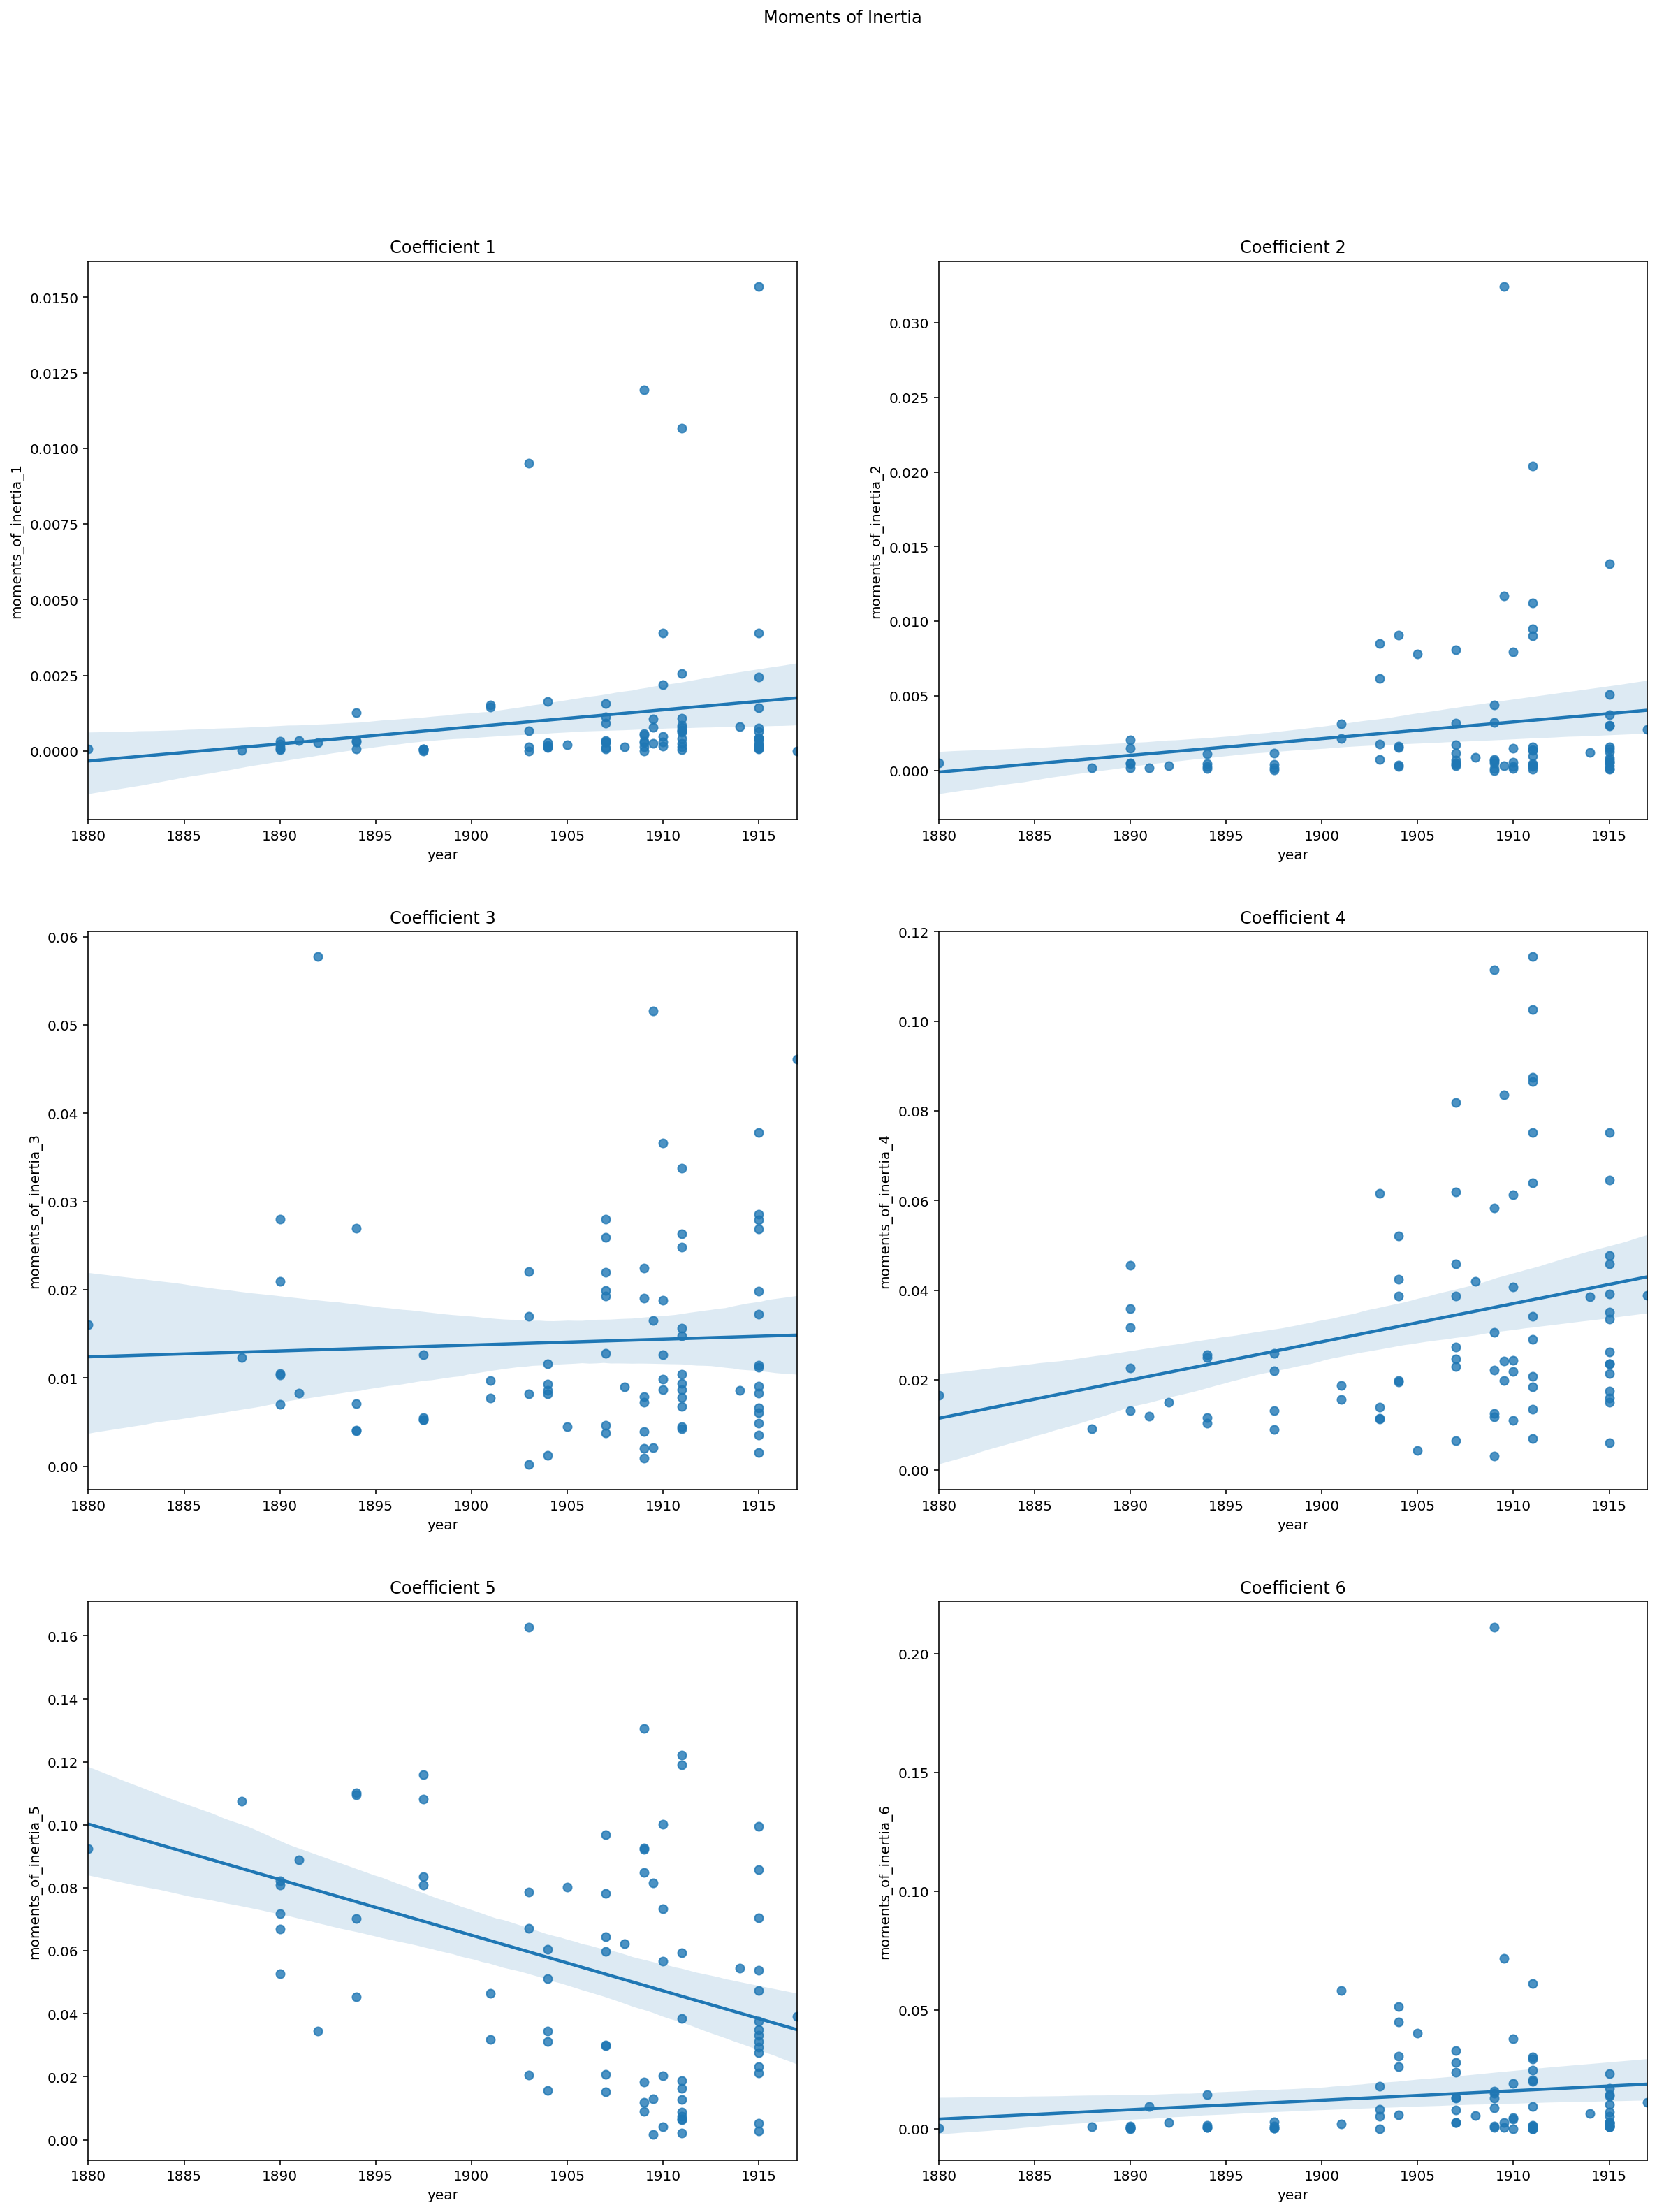

In [12]:
cols = [f"moments_of_inertia_{i}" for i in range(1,7)]
print(len(cols))
metadata_metrics = get_metric('moment_of_inertia', metadata_metrics, 
                              max_coeffs=max_coeffs,
                              max_mags=max_mags,
                              cols=cols, store_matrix=True,
                              testing=True, 
                              show_plot=True, save_name='moments_of_inertia', title='Moments of Inertia')
metadata_metrics.head(1)

# Prevalence of each coefficient

Prevalence of coefficient $n$ in a piece: $W(n)=1/N \sum_{i \in S(n)} i$ where $N$ is the total number of nodes in the wavescape, $S(n)$ is the set of the indices of the nodes in the summary wavescapes that are attributed to coefficient $n$ (i.e., where coefficient $n$ is the most prominent among the six).

Found matrices for all files listed in metadata.tsv.
The example center of mass list has len 6.
Example results [0.49846261 0.00105386 0.07768796 0.16127752 0.25954672 0.00197134]
testing results
                            OLS Regression Results                            
Dep. Variable:                  value   R-squared:                       0.057
Model:                            OLS   Adj. R-squared:                  0.033
Method:                 Least Squares   F-statistic:                     2.416
Date:                Thu, 07 Apr 2022   Prob (F-statistic):            0.00847
Time:                        15:51:39   Log-Likelihood:                -569.71
No. Observations:                 410   AIC:                             1161.
Df Residuals:                     399   BIC:                             1206.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
              

,rel_paths,last_mc,last_mn,length_qb,length_qb_unfolded,all_notes_qb,n_onsets,TimeSig,KeySig,label_count,...,moments_of_inertia_3,moments_of_inertia_4,moments_of_inertia_5,moments_of_inertia_6,percentage_resonances_1,percentage_resonances_2,percentage_resonances_3,percentage_resonances_4,percentage_resonances_5,percentage_resonances_6
l000_etude,MS3,73,71,284.0,284.0,959.25,2473,1: 4/4,"1: -4, 7: 0, 9: -5, 38: 0, 42: -4, 48: -3, 57:...",0,...,0.01726,0.064608,0.034895,0.000976,0.498463,0.001054,0.077688,0.161278,0.259547,0.001971


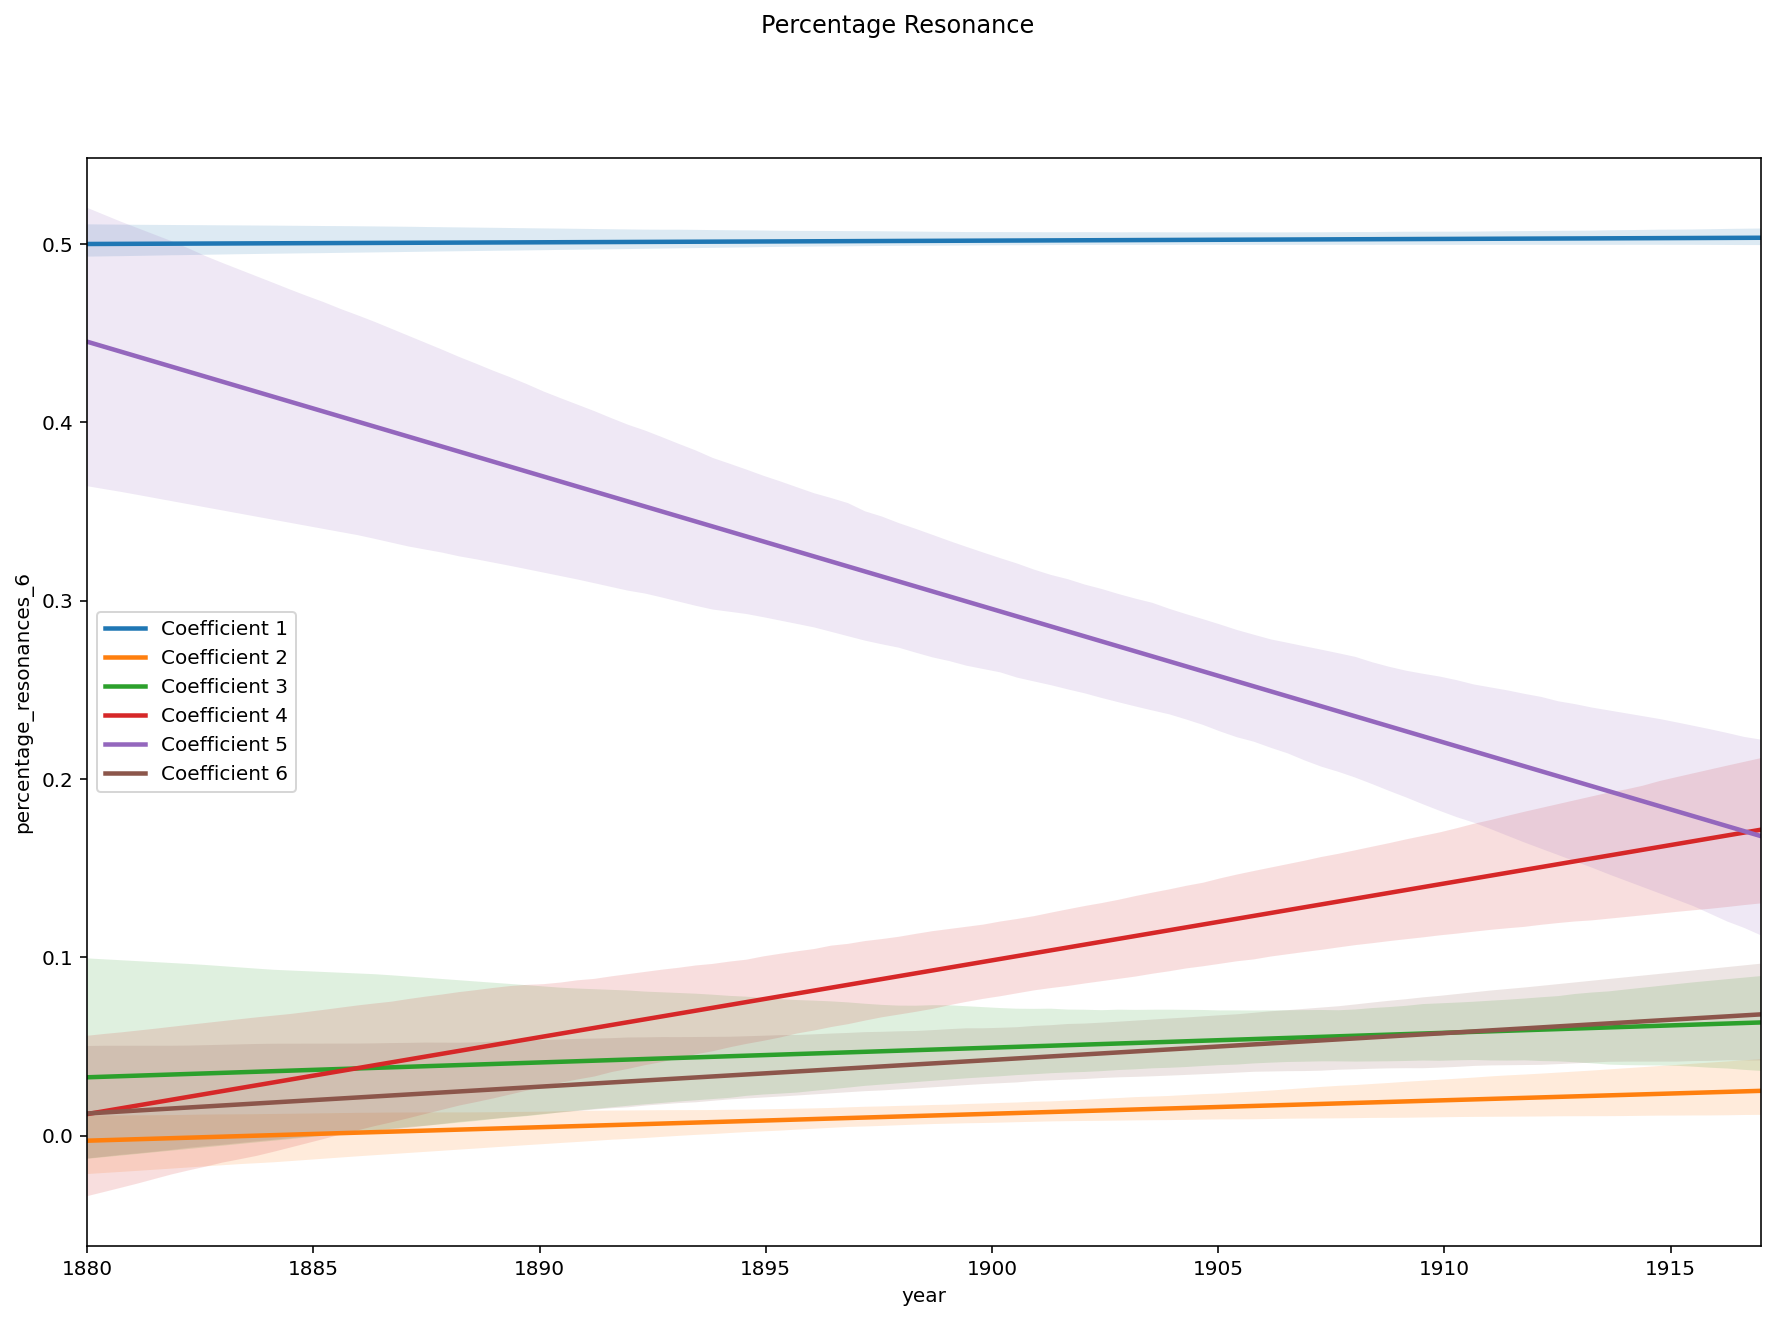

In [13]:
cols = [f"percentage_resonances_{i}" for i in range(1,7)]

metadata_metrics = get_metric('percentage_resonance', metadata_metrics, 
                              max_coeffs=max_coeffs,
                              cols=cols, store_matrix=True, testing=True,
                              show_plot=True, save_name='percentage_resonance', title='Percentage Resonance', unified=True)
metadata_metrics.head(1)

In order to account for the certainty that a certain coefficient is actually the most resonance, we weigh the previous metric by entropy as follows: $W(n)=1/N \sum_{i \in S(n)} w_i$ where $N$ is the total number of nodes in the wavescape, $S(n)$ is the set of the indices of the nodes in the summary wavescapes that are attributed to coefficient $n$ (i.e., where coefficient $n$ is the most prominent among the six), and $w_i$ is the weight (opacity) of the $i$-th node in the summary wavescape, in this case, the entropy of $i$.



Found matrices for all files listed in metadata.tsv.
The example center of mass list has len 6.
Example results [1.84134713e-05 1.72328283e-04 1.81269267e-02 3.73400426e-02
 5.67370571e-02 2.92257347e-04]


c:\Users\ludov\OneDrive\Desktop\debussy\utils.py:534: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metadata_sm[cols] = scaler.fit_transform(metadata_sm[cols])


testing results
                            OLS Regression Results                            
Dep. Variable:                  value   R-squared:                       0.048
Model:                            OLS   Adj. R-squared:                  0.024
Method:                 Least Squares   F-statistic:                     1.990
Date:                Thu, 07 Apr 2022   Prob (F-statistic):             0.0332
Time:                        15:51:55   Log-Likelihood:                -564.69
No. Observations:                 405   AIC:                             1151.
Df Residuals:                     394   BIC:                             1195.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                                          coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------

,rel_paths,last_mc,last_mn,length_qb,length_qb_unfolded,all_notes_qb,n_onsets,TimeSig,KeySig,label_count,...,percentage_resonances_3,percentage_resonances_4,percentage_resonances_5,percentage_resonances_6,percentage_resonances_entropy_1,percentage_resonances_entropy_2,percentage_resonances_entropy_3,percentage_resonances_entropy_4,percentage_resonances_entropy_5,percentage_resonances_entropy_6
l000_etude,MS3,73,71,284.0,284.0,959.25,2473,1: 4/4,"1: -4, 7: 0, 9: -5, 38: 0, 42: -4, 48: -3, 57:...",0,...,0.077688,0.161278,0.259547,0.001971,0.000018,0.000172,0.018127,0.03734,0.056737,0.000292


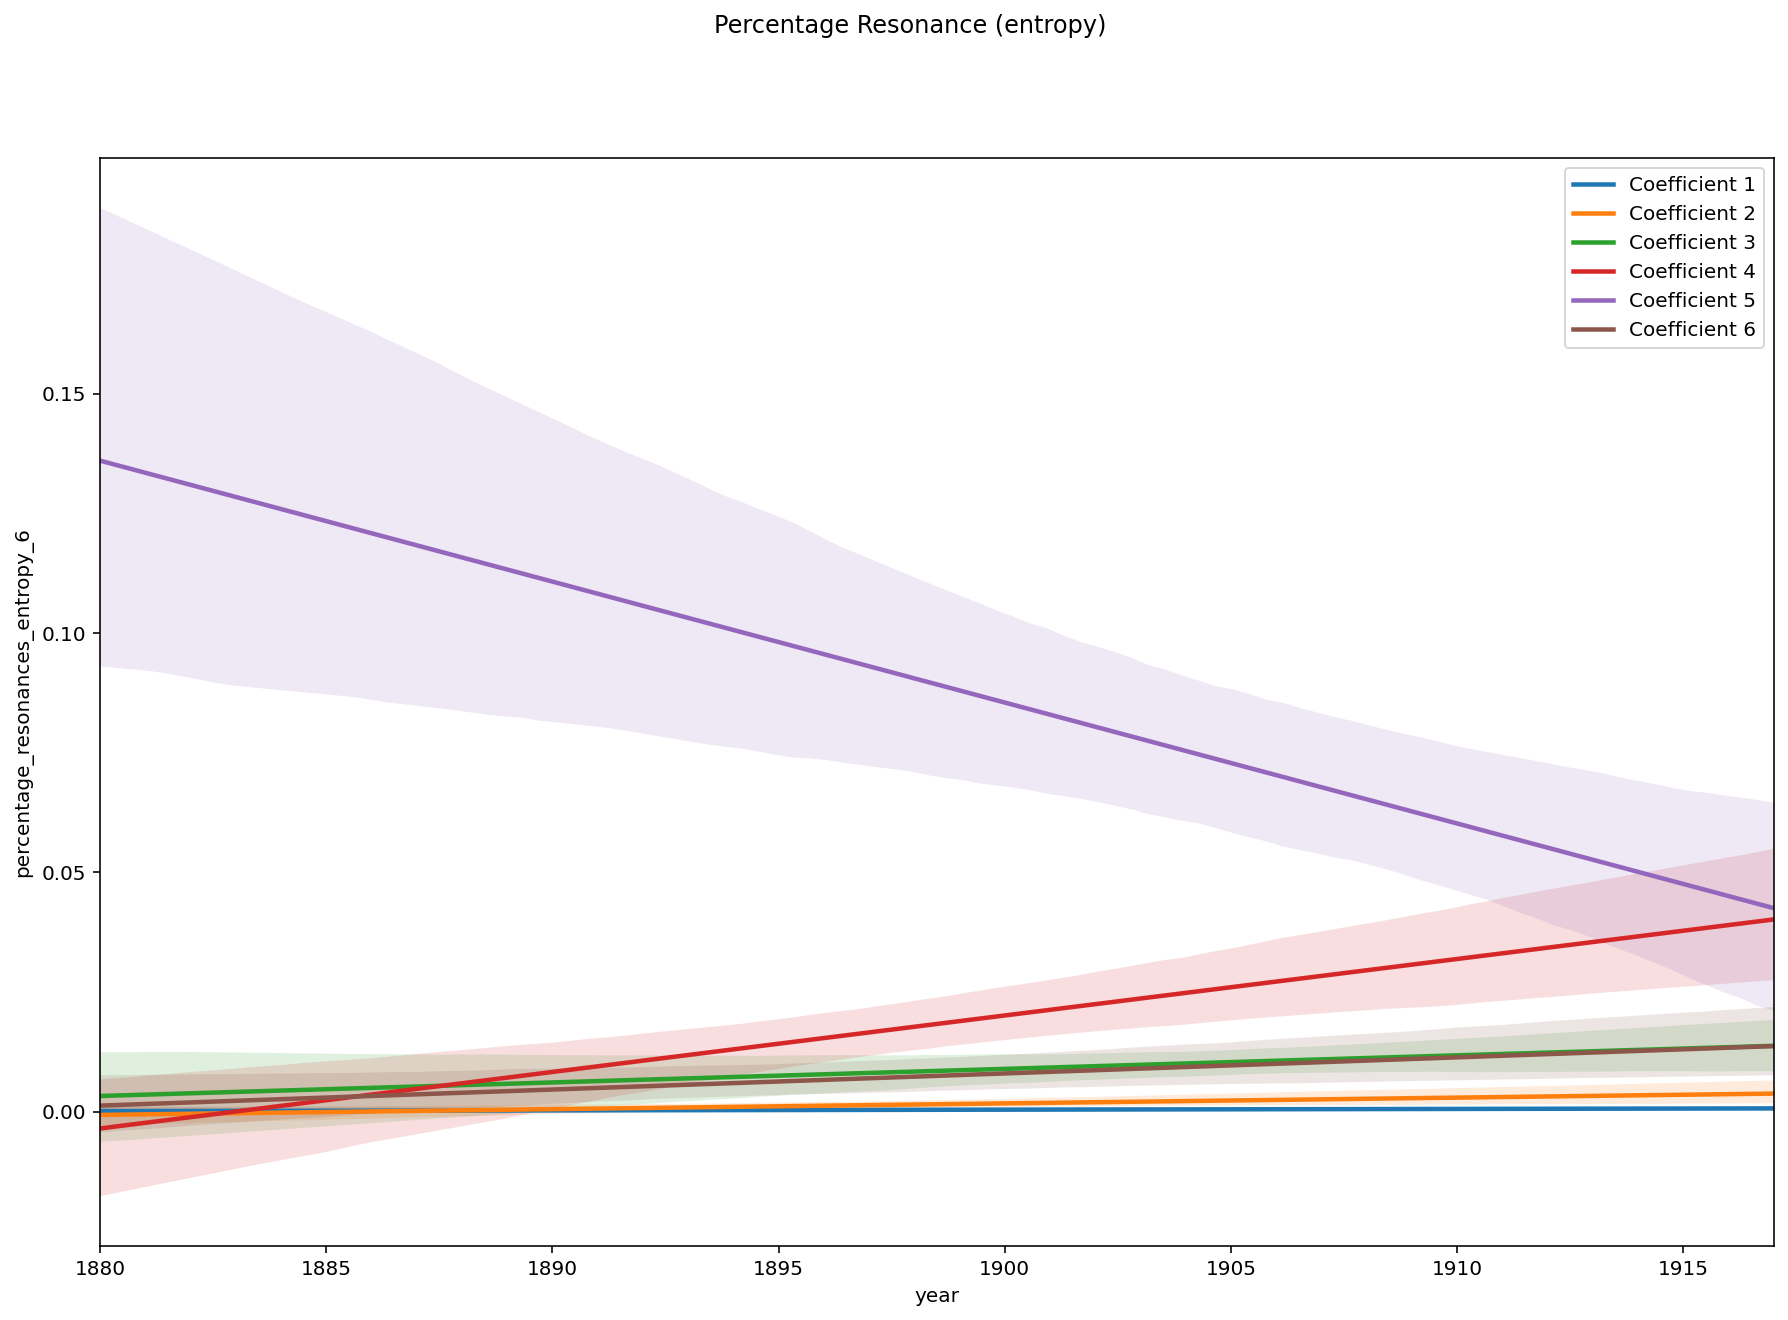

In [14]:
cols = [f"percentage_resonances_entropy_{i}" for i in range(1,7)]

metadata_metrics = get_metric('percentage_resonance_entropy', metadata_metrics, 
                              max_coeffs=max_coeffs,
                              inv_entropies=inv_entropies,
                              cols=cols, store_matrix=True, 
                              testing=True,
                              show_plot=True, save_name='percentage_resonance_entropy', title='Percentage Resonance (entropy)', unified=True)
metadata_metrics.head(1)

# Measure Theoretic Entropy

Measure-theoretic entropy: Let $A={A_1,...,A_k}$ be a (finite) partition of a probability space $(X,P(X),)$: the entropy of the partition $A$ is defined as $H(A)= - \sum_{i} \mu(A_i) \log \mu(A_i)$. We can take $X$ as the support of the wavescape, $A$ as the set of the connected regions in the unified wavescape, and $\mu(Y)=(area-of-Y)/(area-of-X)$ for any subset $Y$ of the wavescape.


In [15]:
# takes quite long
cols = 'partition_entropy'
### add interaction year length
metadata_metrics = get_metric('partition_entropy', metadata_metrics, 
                              max_coeffs=max_coeffs,
                              cols=cols, store_matrix=True, scatter=True, testing=True,
                              show_plot=True, save_name='partition_entropy', title='Partition Entropy', unified=True)
metadata_metrics.head(1)

# Decreasing magnitude in height

The inverse coherence is the slope of the regression line that starts from the magnitude resonance in the summary wavescape at bottom of the wavescape and reaches the one at the top of the wavescape.

,rel_paths,last_mc,last_mn,length_qb,length_qb_unfolded,all_notes_qb,n_onsets,TimeSig,KeySig,label_count,...,percentage_resonances_7,percentage_resonances_entropy_1,percentage_resonances_entropy_2,percentage_resonances_entropy_3,percentage_resonances_entropy_4,percentage_resonances_entropy_5,percentage_resonances_entropy_6,percentage_resonances_entropy_7,partition_entropy,inverse_coherence
l000_etude,MS3,73,71,284.0,284.0,959.25,2473,1: 4/4,"1: -4, 7: 0, 9: -5, 38: 0, 42: -4, 48: -3, 57:...",0,...,0.089739,0.000018,0.000168,0.01815,0.037321,0.03991,0.000292,0.016827,0.130534,0.030475


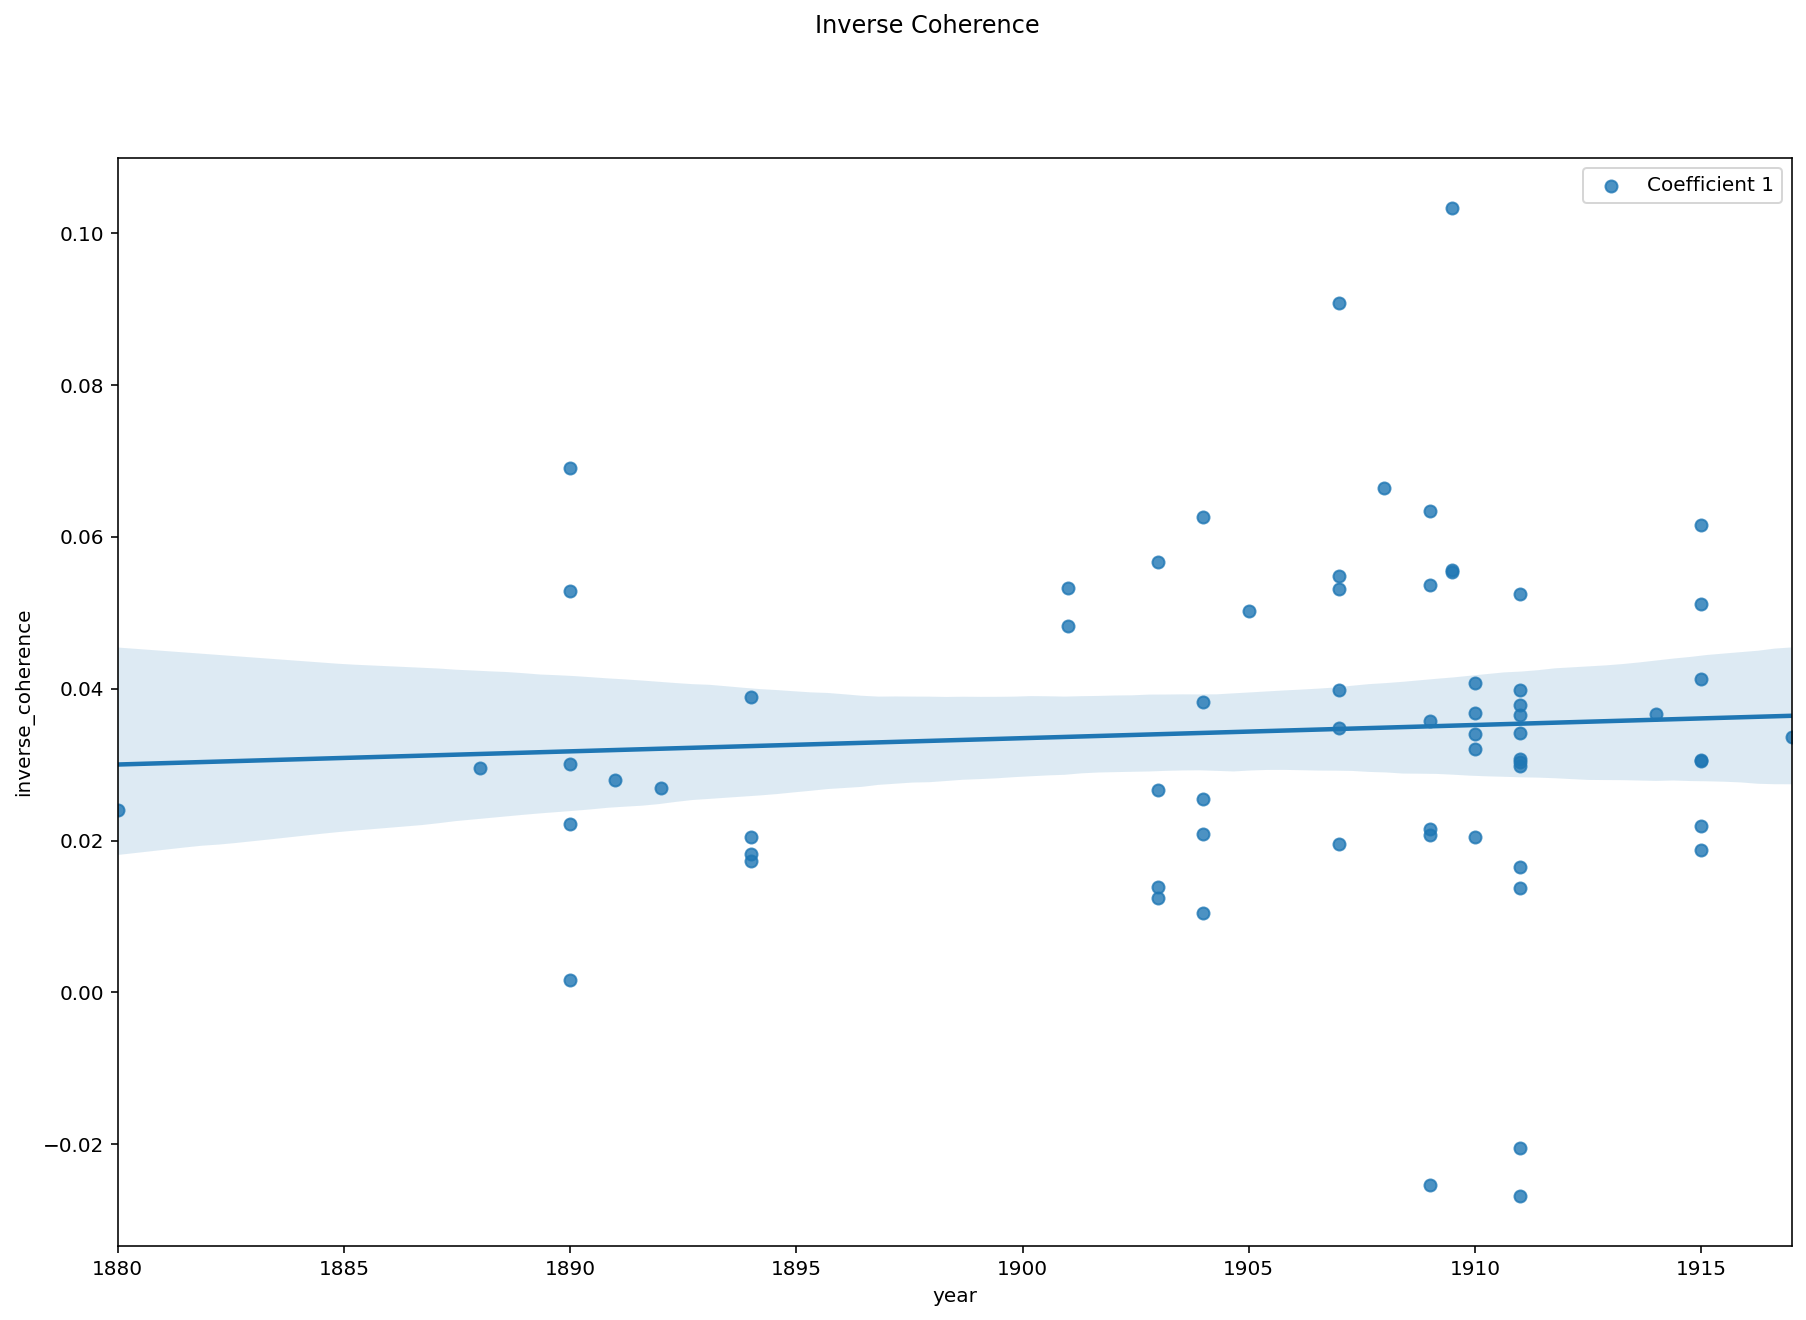

In [ ]:
cols = 'inverse_coherence'

metadata_metrics = get_metric('inverse_coherence', metadata_metrics, 
                              max_mags=max_mags,
                              cols=cols, store_matrix=True, testing=True,
                              show_plot=True, save_name='inverse_coherence', title='Inverse Coherence', unified=True, scatter=True)
metadata_metrics.head(1)

Storing the final metrics for future use:

In [ ]:
metadata_metrics.reset_index().to_csv('metrics_final.csv')